In [1]:
import keras
from keras.datasets import mnist
from keras.models import model_from_json
from keras.utils import np_utils
from keras.optimizers import RMSprop

from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def generate_grads(x, label, model):
    class_output = model.output[:, int(label)]
    
    grads = K.gradients(class_output, model.input)[0]
    gradient_function = K.function([model.input], [grads])

    grads_val = gradient_function([x.reshape(1, 784)])
    
    return np.array(grads_val).reshape(784)

In [3]:
def generate_adv(x, label, model, eps):
    p = np.sign(generate_grads(x, label, model))
    
#     plt.imshow(p.reshape(28,28), 'gray')
#     plt.show()
    
    adv = (x - eps*p).clip(min=0, max=1).reshape(784)
    
    return adv

In [4]:
def predict(x, model):
    pred = model.predict(x.reshape(1,784), batch_size=1)
    pred_class = np.argmax(pred)
    pred_per = max(pred[0])
    
    return pred_class, pred_per

In [5]:
def generate_df(x, label, model, eps):
    p = np.sign(generate_grads(x, label, model))
    
#     plt.imshow(p.reshape(28,28), 'gray')
#     plt.show()
    
    df = (x + eps*p).clip(min=0, max=1).reshape(784)
    
    return df

In [6]:
eps = 0.2

In [7]:
num_classes = 10

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784).astype('float32') / 255
X_test  = X_test.reshape(10000, 784).astype('float32') / 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

y_train_catego = keras.utils.to_categorical(y_train, num_classes)
y_test_catego = keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


In [9]:
# モデルを読み込む
model = model_from_json(open('mnist_mlp_model.json').read())

# 学習結果を読み込む
model.load_weights('mnist_mlp_weights.h5')

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
____________________________________________________________

In [10]:
score = model.evaluate(X_test, y_test_catego, verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 0.10931811571954518
Test accuracy : 0.9842


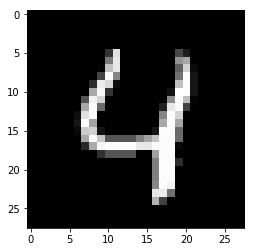

In [11]:
idx = 4
x = X_test[idx]
y = y_test[idx]
plt.imshow(x.reshape(28,28), 'gray')
plt.show()

In [12]:
pred_class, pred_per = predict(x, model)
print(pred_class, pred_per)

4 0.99999833


(784,)


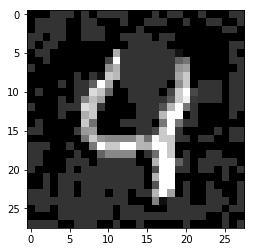

In [13]:
adv = generate_adv(x, y, model, eps)
print(adv.shape)
plt.imshow(adv.reshape(28,28), 'gray')
plt.show()

In [14]:
pred_class, pred_per = predict(adv, model)
print(pred_class, pred_per)

9 0.9890376


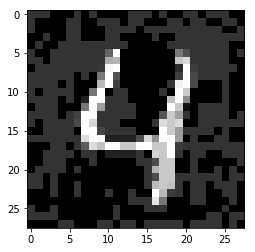

In [15]:
df = generate_df(x, y, model, eps)
plt.imshow(df.reshape(28,28), 'gray')
plt.show()

In [16]:
pred_class, pred_per = predict(df, model)
print(pred_class, pred_per)

4 1.0


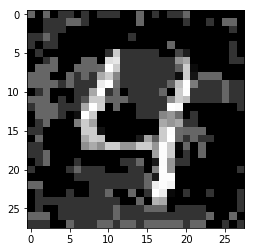

In [17]:
df_adv = generate_adv(df, y, model, eps)
plt.imshow(df_adv.reshape(28,28), 'gray')
plt.show()

In [18]:
pred_class, pred_per = predict(df_adv, model)
print(pred_class, pred_per)

7 1.0


In [19]:
def generate_adv_list(x_list, y_list, model, eps):
    adv_list = []
    
    for x, y in zip(x_list, y_list):
        adv = generate_adv(x, y, model, eps).reshape(784)
        adv_list.append(adv)
        
    return np.array(adv_list)

In [20]:
def generate_df_list(x_list, y_list, model, eps):
    df_list = []
    
    for x, y in zip(x_list, y_list):
        df = generate_adv(x, y, model, eps).reshape(784)
        df_list.append(df)
        
    return np.array(df_list)

In [21]:
max_n = 100

In [22]:
adv_test = generate_adv_list(X_test[:max_n], y_test[:max_n], model, eps)
adv_test.shape

(100, 784)

In [23]:
df_test = generate_df_list(X_test[:max_n], y_test[:max_n], model, eps)
df_test.shape

(100, 784)

In [24]:
df_adv_test = generate_adv_list(df_test, y_test[:max_n], model, eps)
df_adv_test.shape

(100, 784)

In [25]:
score = model.evaluate(X_test[:max_n], y_test_catego[:max_n], verbose=0)
print('x_test')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

x_test
Test loss : 4.2783838143805045e-05
Test accuracy : 1.0


In [26]:
score = model.evaluate(adv_test, y_test_catego[:max_n], verbose=0)
print('adv_test')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

adv_test
Test loss : 12.850388717651366
Test accuracy : 0.03


In [27]:
score = model.evaluate(df_test[:max_n], y_test_catego[:max_n], verbose=0)
print('df_test')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

df_test
Test loss : 12.850388717651366
Test accuracy : 0.03


In [28]:
score = model.evaluate(df_adv_test[:max_n], y_test_catego[:max_n], verbose=0)
print('df_adv_test')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

df_adv_test
Test loss : 16.11809539794922
Test accuracy : 0.0
